# Implementations of the following Algorithms are given below :

1) Classify ImageNet classes with ResNet50
2) Classify MNIST classes with ResNet18 
3) Classify Dog vs Cat Kaggle dataset with Alexnet and Res34
4) Performing an adversarial attack on ImageNet classes


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import os
#import numpy as np
from sklearn import metrics
import pandas as pd
from PIL import Image
import itertools
#import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title:
        ax.set_title(title)
    return ax

class Dataset(object):
    def __init__(self, csv_file, transforms=None):
        super(Dataset, self).__init__()
        self.frame = pd.read_csv(csv_file)
        self.transform = transforms
    def __len__(self):
        return len(self.frame)
    def __getitem__(self, idx):
        img_path = self.frame.loc[idx][0]
        label = self.frame.loc[idx][1]
        img = self.transform(Image.open(img_path))
        
        return img, label


def train(model, dataloader, creiterion, optimizer, scheduler, nepoch, all_epoch):
            
    scheduler.step()
    model.train()
      
    epoch_loss = 0.0
    running_loss = 0.
      
    for batch_idx, output in enumerate(dataloader):
        data, label = output
        data = data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        preds = model(data)
        loss = creiterion(preds, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)] t\Loss: {:.6f}'.format(
                nepoch, all_epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.data.mean()))
            
        running_loss += loss.item()*data.size(0)
              
    epoch_loss += running_loss/len(dataloader.dataset)       
#      torch.save(model.state_dict(), 'Q1_model.pth')
#      torch.save(optimizer.state_dict(), '/results/optimizer.pth')
  
    return model.state_dict()


def test(model, dataloader, creiterion):
    model.eval()
    test_loss = 0.0
    running_corrects = 0.
  
    count  = 0
    with torch.no_grad():
        for output in dataloader:
            count += 1
            data, label = output
            data = data.to(device)
            label = label.to(device)
            
            predictions = model(data)
            
            # calculate accuracy
            _, preds = torch.max(predictions.data, 1)
            running_corrects += torch.sum(preds == label)
            
            # calculate loss     
            test_loss += (creiterion(predictions, label).item())*data.size(0)
            
            preds = preds.cpu()
            label = label.cpu()
            
            # calucalte confusion matrix
            if count == 1:
                label_all = label
                preds_all = preds
            else:
                label_all = torch.cat((label_all, label), dim=0)
                preds_all = torch.cat((preds_all, preds), dim=0)
                
    test_loss /= len(dataloader.dataset)
    acc = round((100. *running_corrects / len(dataloader.dataset)),2)
    
#  test_losses.append(test_loss)
#  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
#    test_loss, 100. * running_corrects / len(dataloader.dataset)))
        
    print('Accuracy: {:.0f}%\n'.format(100. * running_corrects / len(dataloader.dataset)))
    
    return label_all, preds_all, acc
    

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

In [2]:
# Question 1

# create csv file
root = '.'
folder = 'test_imgset'
dirr = root + '/' + folder
folder_name = os.listdir(dirr)

f = open('test_img_list.csv', 'w')
f.write('img_path, label \n')
for i in folder_name:
    label = i.split('_')[-1]
    img_path = dirr + '/' + i
    img_name = os.listdir(img_path)
    for name in img_name:
#        f = open('test_img_list.csv', 'w')
        f.write(img_path+ '/'+name +','+label+'\n')
f = open('test_img_list.csv', 'w')

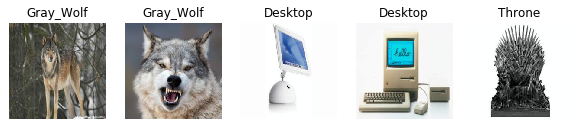

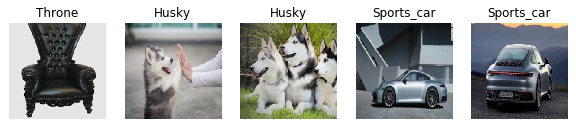

In [7]:
# Parameters

csv_name = 'test_img_list.csv'

root = '.'

model_ft = torchvision.models.resnet50(pretrained = True)
model_ft = model_ft.to(device)

datatransform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), 
                                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
dataset = Dataset(csv_name, datatransform)
dataloader_test = torch.utils.data.DataLoader(dataset, batch_size = 5, shuffle=False)


# data visulation
label_index = {250:'Husky', 269:'Gray_Wolf', 527:'Desktop', 817:'Sports_car', 857:'Throne'}
#images, labels = next(iter(dataloader_test))
for idx, data in enumerate(dataloader_test):
    images, labels = data
    labels = labels.tolist()
    fig, axes = plt.subplots(figsize=(10,10), ncols=5)
    for ii in range(5):
        ax = axes[ii]
        imshow(images[ii], ax=ax, title = label_index[labels[ii]], normalize=True)


Accuracy: 80%



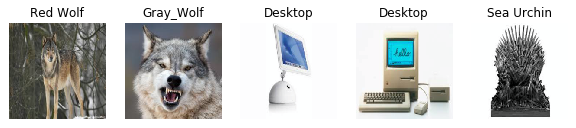

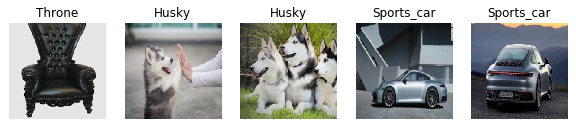

In [9]:
# Calculate accuracy
criterion = nn.CrossEntropyLoss()

all_label, all_preds = test(model_ft, dataloader_test, criterion)

#images, labels = next(iter(dataloader_test))
preds_index = {250:'Husky', 269:'Gray_Wolf', 271:'Red Wolf', 
               328: 'Sea Urchin', 527:'Desktop', 817:'Sports_car', 857:'Throne'}
for idx, data in enumerate(dataloader_test):
    images, labels = data   
    labels = all_preds[idx*5: idx*5+5].tolist()
    fig, axes = plt.subplots(figsize=(10,10), ncols=5)
    for ii in range(5):
        ax = axes[ii]
        imshow(images[ii], ax=ax, title = preds_index[labels[ii]], normalize=True)

Confusion matrix, without normalization
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 1 0 0 1]]


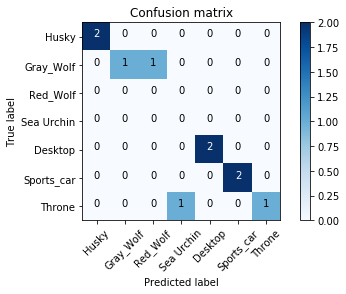

In [24]:
# Confusion matrix
# redefine the label to other
# Calculate confusion matrix
# Husky 250 = 0; # wolf 269 = 1; #desktop 527 = 2; #sports_car 817 = 3; throne 857 = 4; other = 5
names = ['Husky', 'Gray_Wolf', 'Red_Wolf', 'Sea Urchin', 'Desktop', 'Sports_car', 'Throne']
cm = metrics.confusion_matrix(all_label, all_preds)
plt.figure()
plot_confusion_matrix(cm, names)

In [20]:
# Classification report
# redefine the label
all_label_list = all_label.tolist()
all_preds_list = all_preds.tolist()

for i in range(len(all_label)):
    if all_label_list[i] == 250:
        all_label_list[i] = preds_index[all_label_list[i]]
    elif all_label_list[i] == 269:
        all_label_list[i] = preds_index[all_label_list[i]]
    elif all_label_list[i] == 527:
        all_label_list[i] = preds_index[all_label_list[i]]
    elif all_label_list[i] == 817:
        all_label_list[i] = preds_index[all_label_list[i]]
    elif all_label_list[i] == 857:
        all_label_list[i] = preds_index[all_label_list[i]]
        
        
for i in range(len(all_preds)):
    if all_preds_list[i] == 250:
        all_preds_list[i] = preds_index[all_preds_list[i]]
    elif all_preds_list[i] == 269:
        all_preds_list[i] = preds_index[all_preds_list[i]]
    elif all_preds_list[i] == 527:
        all_preds_list[i] = preds_index[all_preds_list[i]]
    elif all_preds_list[i] == 817:
        all_preds_list[i] = preds_index[all_preds_list[i]]
    elif all_preds_list[i] == 857:
        all_preds_list[i] = preds_index[all_preds_list[i]]
    elif all_preds_list[i] == 328:
        all_preds_list[i] = preds_index[all_preds_list[i]]
    elif all_preds_list[i] == 271:
        all_preds_list[i] = preds_index[all_preds_list[i]]
        
print(metrics.classification_report(all_label_list, all_preds_list, digits=3))

              precision    recall  f1-score   support

     Desktop      1.000     1.000     1.000         2
   Gray_Wolf      1.000     0.500     0.667         2
       Husky      1.000     1.000     1.000         2
    Red Wolf      0.000     0.000     0.000         0
  Sea Urchin      0.000     0.000     0.000         0
  Sports_car      1.000     1.000     1.000         2
      Throne      1.000     0.500     0.667         2

   micro avg      0.800     0.800     0.800        10
   macro avg      0.714     0.571     0.619        10
weighted avg      1.000     0.800     0.867        10



In [25]:
# Question 2


# Prepare dataset
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root = './data/', train=True, download=True, transform= data_transform)
test_dataset = torchvision.datasets.MNIST(root = './data/', train=False, download=True,transform= data_transform)
    
# Build model   
model_conv = torchvision.models.resnet18(pretrained = True)
model_conv.conv1.weight = nn.Parameter(model_conv.conv1.weight.sum(dim=1).unsqueeze(1).data)
for param in model_conv.parameters():
    param.requires_grad = False

# Only retrain the last fc layer
model_conv.fc = nn.Linear(512, 10)
# Train parameters
params_to_update = []                    
print("Params to learn:")
for name,param in model_conv.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
model_conv.to(device)
                    
# Optimizer
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)         
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Params to learn:
('\t', 'fc.weight')
('\t', 'fc.bias')


In [28]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
log_interval = 100

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

#epoch_preds = []
#epoch_labels = []

# Train and test your model
for epoch in range(1, n_epochs + 1):
    last_model_wts = train(model_conv, train_loader, criterion, optimizer_ft, exp_lr_scheduler, epoch, n_epochs)
    labell, predd, accc = test(model_conv, test_loader, criterion)
    
    #epoch_labels.append(labell)
    #epoch_preds.append(predd)

torch.save(last_model_wts, "Question2.pth")

Train Epoch: 1/3 [0/60000 (0%)] t\Loss: 0.226767
Train Epoch: 1/3 [6400/60000 (11%)] t\Loss: 0.196063
Train Epoch: 1/3 [12800/60000 (21%)] t\Loss: 0.306887
Train Epoch: 1/3 [19200/60000 (32%)] t\Loss: 0.166999
Train Epoch: 1/3 [25600/60000 (43%)] t\Loss: 0.226680
Train Epoch: 1/3 [32000/60000 (53%)] t\Loss: 0.205767
Train Epoch: 1/3 [38400/60000 (64%)] t\Loss: 0.288072
Train Epoch: 1/3 [44800/60000 (75%)] t\Loss: 0.152693
Train Epoch: 1/3 [51200/60000 (85%)] t\Loss: 0.206334
Train Epoch: 1/3 [57600/60000 (96%)] t\Loss: 0.195621
Accuracy: 94%

Train Epoch: 2/3 [0/60000 (0%)] t\Loss: 0.260420
Train Epoch: 2/3 [6400/60000 (11%)] t\Loss: 0.228526
Train Epoch: 2/3 [12800/60000 (21%)] t\Loss: 0.266466
Train Epoch: 2/3 [19200/60000 (32%)] t\Loss: 0.181198
Train Epoch: 2/3 [25600/60000 (43%)] t\Loss: 0.265271
Train Epoch: 2/3 [32000/60000 (53%)] t\Loss: 0.204822
Train Epoch: 2/3 [38400/60000 (64%)] t\Loss: 0.240083
Train Epoch: 2/3 [44800/60000 (75%)] t\Loss: 0.268635
Train Epoch: 2/3 [51200/6

Normalized confusion matrix
[[9.78571429e-01 0.00000000e+00 4.08163265e-03 1.02040816e-03
  1.02040816e-03 2.04081633e-03 8.16326531e-03 1.02040816e-03
  4.08163265e-03 0.00000000e+00]
 [0.00000000e+00 9.85022026e-01 6.16740088e-03 1.76211454e-03
  8.81057269e-04 0.00000000e+00 2.64317181e-03 2.64317181e-03
  8.81057269e-04 0.00000000e+00]
 [2.90697674e-03 9.68992248e-04 9.46705426e-01 1.45348837e-02
  9.68992248e-04 1.55038760e-02 6.78294574e-03 6.78294574e-03
  3.87596899e-03 9.68992248e-04]
 [9.90099010e-04 0.00000000e+00 1.58415842e-02 9.30693069e-01
  9.90099010e-04 3.76237624e-02 9.90099010e-04 4.95049505e-03
  4.95049505e-03 2.97029703e-03]
 [0.00000000e+00 1.01832994e-03 4.07331976e-03 0.00000000e+00
  9.65376782e-01 1.01832994e-03 1.01832994e-03 3.05498982e-03
  5.09164969e-03 1.93482688e-02]
 [0.00000000e+00 0.00000000e+00 1.00896861e-02 4.37219731e-02
  0.00000000e+00 9.30493274e-01 4.48430493e-03 4.48430493e-03
  5.60538117e-03 1.12107623e-03]
 [1.35699374e-02 3.13152401e-0

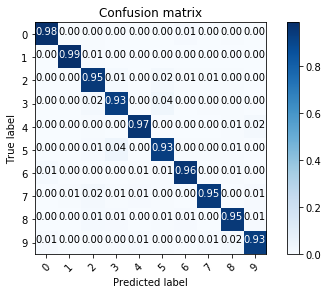

In [31]:
# Calculate confusion matrix and metrics
names = [str(i) for i in range(10)]
cm = metrics.confusion_matrix(labell, predd)
#    plt.figure(figsize=(10,10))
plt.figure()
plot_confusion_matrix(cm, names, normalize = True)

In [32]:
all_label_list = labell.tolist()
all_preds_list = predd.tolist()
        
print(metrics.classification_report(all_label_list, all_preds_list, digits=3))

              precision    recall  f1-score   support

           0      0.971     0.979     0.975       980
           1      0.989     0.985     0.987      1135
           2      0.926     0.947     0.936      1032
           3      0.923     0.931     0.927      1010
           4      0.968     0.965     0.967       982
           5      0.914     0.930     0.922       892
           6      0.964     0.961     0.963       958
           7      0.968     0.946     0.957      1028
           8      0.949     0.950     0.949       974
           9      0.954     0.934     0.944      1009

   micro avg      0.953     0.953     0.953     10000
   macro avg      0.953     0.953     0.953     10000
weighted avg      0.953     0.953     0.953     10000



In [33]:
# Define two networks: One is Alexnet, and the other is Res34

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained):
    # Initialize models
    model_ft = None
    input_size = 0

    if model_name == "Res18" or model_name == "Res34" or model_name == "Res50":
        """ Resnet
        """
        if model_name == "Res18":
            model_ft = torchvision.models.resnet18(pretrained=use_pretrained)
        elif model_name == 'Res34':
            model_ft = torchvision.models.resnet34(pretrained=use_pretrained)
        else:
            model_ft = torchvision.models.resnet50(pretrained=use_pretrained)
#        # Remove last fc layer
#        model_ft = list(model_ft.children())[:-1]
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "Alexnet":
        """ Alexnet
        """
        model_ft = torchvision.models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft.features, feature_extract)
        num_ftrs = model_ft.classifier[-1].in_features        

        model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        input_size = 227
        

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size, num_ftrs


In [ ]:
# Create dataset for traning and testing: 80% for training and 20% for testing
root = '.'
ddir = 'PetImages'
copy_ddir = 'PetImages_dataset'
#for i in Folder_name:
##    os.chdir(root+'/'+i)

os.chdir(root+'/'+ copy_ddir)
os.mkdir('train')
os.mkdir('test')
os.chdir('..')

sub_folder = os.listdir(root+'/'+ddir)
for ii in sub_folder:
    print ii
    imgs = os.listdir(root+'/'+ddir+'/'+ii)
    imgs.sort(key = lambda x: int(x.split('.')[0]))
    train_idx = range(int(0.8*len(imgs)))
    test_idx = range(int(0.8*len(imgs)),len(imgs),1)
    count_1 = 0
    count_2 = 0
    for idx, name in enumerate(imgs):
        if idx in train_idx:
            count_1 += 1

            if count_1 == 1:
                os.chdir(root+'/'+ copy_ddir+'/train')
                os.mkdir(ii)
            os.chdir('/home/endiqq/Desktop/Rutgers/Machine_Vision/Homework/hw_5/')    
            os.rename(root+'/'+ddir+'/'+ii+'/'+name, root+'/'+copy_ddir+'/'+'train/'+ii+'/'+name)
        elif idx in test_idx:
            count_2 += 1
            if count_2 == 1:
                os.chdir(root+'/'+ copy_ddir+'/test')
                os.mkdir(ii)
            os.chdir('/home/endiqq/Desktop/Rutgers/Machine_Vision/Homework/hw_5/')      
            os.rename(root+'/'+ddir+'/'+ii+'/'+name, root+'/'+copy_ddir+'/'+'test/'+ii+'/'+name)

In [36]:

root = '.'
ddir = 'PetImages'
copy_ddir = 'PetImages_dataset'
data_dir = root +'/'+ copy_ddir

NN_set = ["Alexnet","Res34"]
num_classes = 2
feature_extract = 'True'
log_interval = 100
n_epochs = 10

NN_preds = []
NN_labels = []
NN_accs = []

for idx, NN in enumerate(NN_set):
    model, size, num_ftrs = initialize_model(NN, num_classes, feature_extract, use_pretrained='True')
    model.to(device)
    #((size,size))
    
    data_transforms = transforms.Compose([transforms.RandomResizedCrop(size), transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
    train_dataset = datasets.ImageFolder(data_dir +'/train', transform= data_transforms)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
    test_dataset = datasets.ImageFolder(data_dir +'/test', transform= data_transforms)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)
    
    params_to_update = []                    
    print("Params to learn:")
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
            
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)         
    #    criterion = nn.BCELoss()
    criterion = nn.CrossEntropyLoss()
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    
    best_acc = 0
    # Train and test your model
    for epoch in range(1, n_epochs + 1):
        model_wts = train(model, train_dataloader, criterion, optimizer_ft, exp_lr_scheduler, epoch, n_epochs)
        labell, predd, accc = test(model, test_dataloader, criterion)
        
        if accc>=best_acc:
            best_acc = accc
            best_labels = labell
            best_preds = predd
            torch.save(model_wts, "Question3_"+NN+'_best_wts'+".pth")
    NN_preds.append(best_preds)
    NN_labels.append(best_labels)
    NN_accs.append(best_acc)

Params to learn:
('\t', 'classifier.1.weight')
('\t', 'classifier.1.bias')
('\t', 'classifier.4.weight')
('\t', 'classifier.4.bias')
('\t', 'classifier.6.weight')
('\t', 'classifier.6.bias')
Train Epoch: 1/10 [0/19999 (0%)] t\Loss: 0.752797
Train Epoch: 1/10 [6400/19999 (32%)] t\Loss: 0.193451


/home/endiqq/anaconda2/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/endiqq/anaconda2/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/endiqq/anaconda2/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/endiqq/anaconda2/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/endiqq/anaconda2/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Pos

Train Epoch: 1/10 [12800/19999 (64%)] t\Loss: 0.178649
Train Epoch: 1/10 [19200/19999 (96%)] t\Loss: 0.174637
Accuracy: 93%

Train Epoch: 2/10 [0/19999 (0%)] t\Loss: 0.302189
Train Epoch: 2/10 [6400/19999 (32%)] t\Loss: 0.155320
Train Epoch: 2/10 [12800/19999 (64%)] t\Loss: 0.216312
Train Epoch: 2/10 [19200/19999 (96%)] t\Loss: 0.169238
Accuracy: 93%

Train Epoch: 3/10 [0/19999 (0%)] t\Loss: 0.123878
Train Epoch: 3/10 [6400/19999 (32%)] t\Loss: 0.109733
Train Epoch: 3/10 [12800/19999 (64%)] t\Loss: 0.310113
Train Epoch: 3/10 [19200/19999 (96%)] t\Loss: 0.217654
Accuracy: 93%

Train Epoch: 4/10 [0/19999 (0%)] t\Loss: 0.207254
Train Epoch: 4/10 [6400/19999 (32%)] t\Loss: 0.192300
Train Epoch: 4/10 [12800/19999 (64%)] t\Loss: 0.139562
Train Epoch: 4/10 [19200/19999 (96%)] t\Loss: 0.106105
Accuracy: 93%

Train Epoch: 5/10 [0/19999 (0%)] t\Loss: 0.066861
Train Epoch: 5/10 [6400/19999 (32%)] t\Loss: 0.130919
Train Epoch: 5/10 [12800/19999 (64%)] t\Loss: 0.116842
Train Epoch: 5/10 [19200/1999

The overall highest accuracy is 94.0%


Normalized confusion matrix
[[0.9604     0.0396    ]
 [0.03881553 0.96118447]]
              precision    recall  f1-score   support

         Cat      0.932     0.950     0.941      2500
         Dog      0.949     0.931     0.940      2499

   micro avg      0.941     0.941     0.941      4999
   macro avg      0.941     0.941     0.941      4999
weighted avg      0.941     0.941     0.941      4999



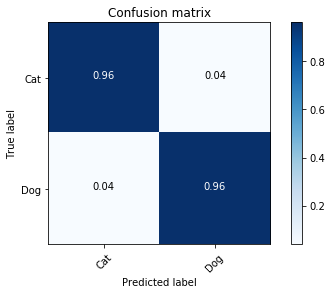

In [67]:
# Metrics for Alexnet

print('The overall highest accuracy is {}%'.format(NN_accs[0]))  
print("\n")
names = ['Cat', 'Dog']
cm = metrics.confusion_matrix(labell, predd)
#    plt.figure(figsize=(10,10))
plt.figure()
plot_confusion_matrix(cm, names, normalize = True)

# Classification report
all_label_list = NN_labels[0].tolist()
all_preds_list = NN_preds[0].tolist()

# redefine label
for i in range(len(all_label_list)):
    if all_label_list[i] == 0:
        all_label_list[i] = 'Cat'
    else:
        all_label_list[i] = 'Dog'

for i in range(len(all_label_list)):
    if all_preds_list[i] == 0:
        all_preds_list[i] = 'Cat'
    else:
        all_preds_list[i] = 'Dog'
     
print(metrics.classification_report(all_label_list, all_preds_list, digits=3))

The overall highest accuracy is 96.0%


Normalized confusion matrix
[[0.9604     0.0396    ]
 [0.03881553 0.96118447]]
              precision    recall  f1-score   support

         Cat      0.957     0.964     0.960      2500
         Dog      0.964     0.956     0.960      2499

   micro avg      0.960     0.960     0.960      4999
   macro avg      0.960     0.960     0.960      4999
weighted avg      0.960     0.960     0.960      4999



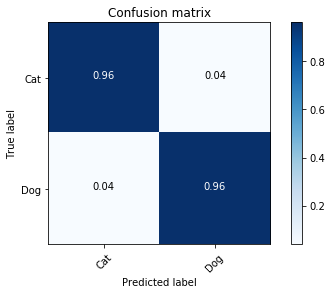

In [66]:

# Metrics for Resnet34

print('The overall highest accuracy is {}%'.format(NN_accs[1]))  
print("\n")
names = ['Cat', 'Dog']
cm = metrics.confusion_matrix(labell, predd)
#    plt.figure(figsize=(10,10))
plt.figure()
plot_confusion_matrix(cm, names, normalize = True)

# Classification report
all_label_list = NN_labels[1].tolist()
all_preds_list = NN_preds[1].tolist()

# redefine label
for i in range(len(all_label_list)):
    if all_label_list[i] == 0:
        all_label_list[i] = 'Cat'
    else:
        all_label_list[i] = 'Dog'

for i in range(len(all_label_list)):
    if all_preds_list[i] == 0:
        all_preds_list[i] = 'Cat'
    else:
        all_preds_list[i] = 'Dog'
     
print(metrics.classification_report(all_label_list, all_preds_list, digits=3))

In [5]:
# Question 4
# Create noise dataset
class Dataset_noise(object):
    def __init__(self, csv_file, transforms=None):
        super(Dataset_noise, self).__init__()
        self.frame = pd.read_csv(csv_file)
        self.transform = transforms
        self.noise = torch.randn(len(self.frame),3,224,224).normal_(0,1)
    def __len__(self):
        return len(self.frame)
    def __getitem__(self, idx):
        img_path = self.frame.loc[idx][0]
        label = self.frame.loc[idx][1]
        img = self.transform(Image.open(img_path))
        img = img + self.noise[idx]
        return img, label

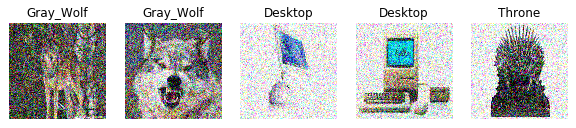

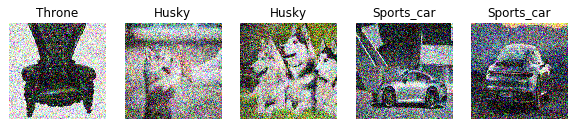

In [9]:
# Parameters
root = '.'
csv_name = 'test_img_list.csv'

model_ft = torchvision.models.resnet50(pretrained = True)
model_ft = model_ft.to(device)

datatransform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), 
                                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
dataset = Dataset_noise(csv_name, datatransform)
dataloader_test = torch.utils.data.DataLoader(dataset, batch_size = 5, shuffle=False)


# noise data visulation
label_index = {250:'Husky', 269:'Gray_Wolf', 527:'Desktop', 817:'Sports_car', 857:'Throne'}
#images, labels = next(iter(dataloader_test))
for idx, data in enumerate(dataloader_test):
    images, labels = data
    labels = labels.tolist()
    fig, axes = plt.subplots(figsize=(10,10), ncols=5)
    for ii in range(5):
        ax = axes[ii]
        imshow(images[ii], ax=ax, title = label_index[labels[ii]], normalize=True)

In [10]:
# Test accuracy
criterion = nn.CrossEntropyLoss()
all_label, all_preds, accc = test(model_ft, dataloader_test, criterion)

Accuracy: 0%



Confusion matrix, without normalization
[[0 0 0 0 0 2]
 [0 0 0 0 0 2]
 [0 0 0 0 0 2]
 [0 0 0 0 0 2]
 [0 0 0 0 0 2]
 [0 0 0 0 0 0]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         2
           1      0.000     0.000     0.000         2
           2      0.000     0.000     0.000         2
           3      0.000     0.000     0.000         2
           4      0.000     0.000     0.000         2
           5      0.000     0.000     0.000         0

   micro avg      0.000     0.000     0.000        10
   macro avg      0.000     0.000     0.000        10
weighted avg      0.000     0.000     0.000        10



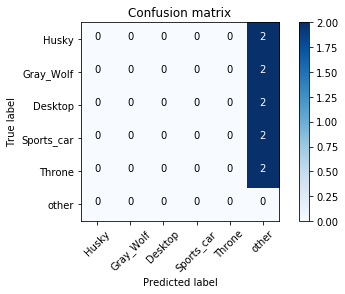

In [12]:
# Confusion matrix and classification report
all_label_list = all_label.tolist()
all_preds_list = all_preds.tolist()

for i in range(len(all_label)):
    if all_label_list[i] == 250:
        all_label_list[i] = 0
    elif all_label_list[i] == 269:
        all_label_list[i] = 1
    elif all_label_list[i] == 527:
        all_label_list[i] = 2
    elif all_label_list[i] == 817:
        all_label_list[i] = 3
    elif all_label_list[i] == 857:
        all_label_list[i] = 4
    else:
        all_label_list[i] = 5
        
        
for i in range(len(all_preds)):
    if all_preds_list[i] == 250:
        all_preds_list[i] = 0
    elif all_preds_list[i] == 269:
        all_preds_list[i] = 1
    elif all_preds_list[i] == 527:
        all_preds_list[i] = 2
    elif all_preds_list[i] == 817:
        all_preds_list[i] = 3
    elif all_preds_list[i] == 857:
        all_preds_list[i] = 4
    else:
        all_preds_list[i] = 5
            
names = ['Husky', 'Gray_Wolf', 'Desktop', 'Sports_car', 'Throne', 'other']
cm = metrics.confusion_matrix(all_label_list, all_preds_list)
plt.figure()
plot_confusion_matrix(cm, names)

# classifcation report
print(metrics.classification_report(all_label_list, all_preds_list, digits=3))